In [54]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
from PIL import Image
import torch.optim as optim
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix 

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    # 'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    # 'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    # 'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    # 'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

In [18]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [19]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

In [20]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [21]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [22]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_heads, num_classes=7):
        self.inplanes = 64
        # self.embed_dim = embed_dim
        self.num_heads = num_heads
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.attention = nn.MultiheadAttention(256, num_heads)
        self.layer_norm = nn.LayerNorm(256)
        self.classifier = nn.Linear(256, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, height*width).permute(0,2,1)

        query = x
        key = x
        value = x

        attn_output, _ = self.attention(query, key, value)
        x = self.layer_norm(attn_output + x)
        x = x.permute(0,2,1).view(batch_size, channels, height, width)
        x = nn.functional.adaptive_avg_pool2d(x,1).view(batch_size, -1)

        logits = self.classifier(x)

        return logits

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Class Labels are 0-Indexed CAREFULL

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Read the CSV file
        self.data_frame = pd.read_csv(csv_file)

        # Ensure the CSV file has columns 'filename' and 'class'
        assert 'image' in self.data_frame.columns
        assert 'label' in self.data_frame.columns

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get the filename and class label
        img_name = self.data_frame.iloc[idx, 0]  # Get the filename from the CSV
        class_label = self.data_frame.iloc[idx, 1] - 1  # Get the class label from the CSV

        # Construct the path to the image based on its class label
        class_folder = os.path.join(self.image_dir, str(class_label+1))  # Convert class label to string
        img_path = os.path.join(class_folder, img_name)

        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, class_label

In [13]:
image_directory = r"/kaggle/input/raf-db-dataset/DATASET/train"  # Directory containing class subfolders
csv_file_path = r"/kaggle/input/raf-db-dataset/train_labels.csv"

In [14]:
train_dataset = CustomImageDataset(image_dir=image_directory, csv_file=csv_file_path, transform=transform)


In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, pin_memory=True, shuffle=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
torch.cuda.empty_cache()

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
def resnet18_cbam(pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    num_heads = 2
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_heads)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict, strict=False)
    return model

In [25]:
model = resnet18_cbam()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc): Sequential(
          (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [27]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [28]:
os.makedirs('models', exist_ok=True)

In [29]:
os.getcwd()

'/kaggle/working'

In [30]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=5):
    # train_loader = pl.MpDeviceLoader(train_loader, device)
    model.train()
    # os.makedirs('models', exist_ok=True)
    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs=model(images)
            loss = criterion(outputs,labels)

            loss.backward()
            optimizer.step()
            # xm.optimizer_step(optimizer)

            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        if epoch > 2 :
          torch.save({'iter': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),},
                    os.path.join('models', "epoch_"+str(epoch)+"_loss_"+str(epoch_loss)+".pth"))
          print('Model saved.')

In [31]:
train(model, train_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 384/384 [00:41<00:00,  9.30it/s]


Epoch [1/5], Loss: 1.2328


100%|██████████| 384/384 [00:40<00:00,  9.53it/s]


Epoch [2/5], Loss: 0.8029


100%|██████████| 384/384 [00:40<00:00,  9.58it/s]


Epoch [3/5], Loss: 0.6365


100%|██████████| 384/384 [00:40<00:00,  9.51it/s]


Epoch [4/5], Loss: 0.5159
Model saved.


100%|██████████| 384/384 [00:40<00:00,  9.58it/s]


Epoch [5/5], Loss: 0.4130
Model saved.


In [44]:
test_image_directory = r"D:/RAF-DB/DATASET/test"
test_csv_file_path = r"D:/RAF-DB/test_labels.csv"

In [45]:
os.getcwd()

'D:\\Facial-Expression-Recognition-Using-Self-Attention'

In [46]:
test_dataset = CustomImageDataset(test_image_directory, test_csv_file_path, transform)

In [47]:
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=False)

In [48]:
os.getcwd()

'D:\\Facial-Expression-Recognition-Using-Self-Attention'

In [49]:
checkpoint = torch.load(r"epoch-models/epoch_4_loss_0.4130449585500173.pth", map_location=torch.device('cpu'))

In [50]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc): Sequential(
          (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [51]:
all_preds=[]
all_labels=[]
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs,1)
#         predicted+=1
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [04:38<00:00,  2.90s/it]


In [52]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
accuracy

0.7542372881355932

In [55]:
cm = confusion_matrix(all_labels, all_preds)
cm

array([[ 198,    2,    7,   61,   35,    3,   23],
       [   9,   12,    4,   26,   12,    7,    4],
       [   0,    0,   71,   32,   36,    5,   16],
       [   2,    0,    6, 1140,   21,    0,   16],
       [   1,    0,   14,   46,  356,    0,   61],
       [   3,    0,   21,   40,   17,   74,    7],
       [   5,    0,   34,  117,   61,    0,  463]], dtype=int64)

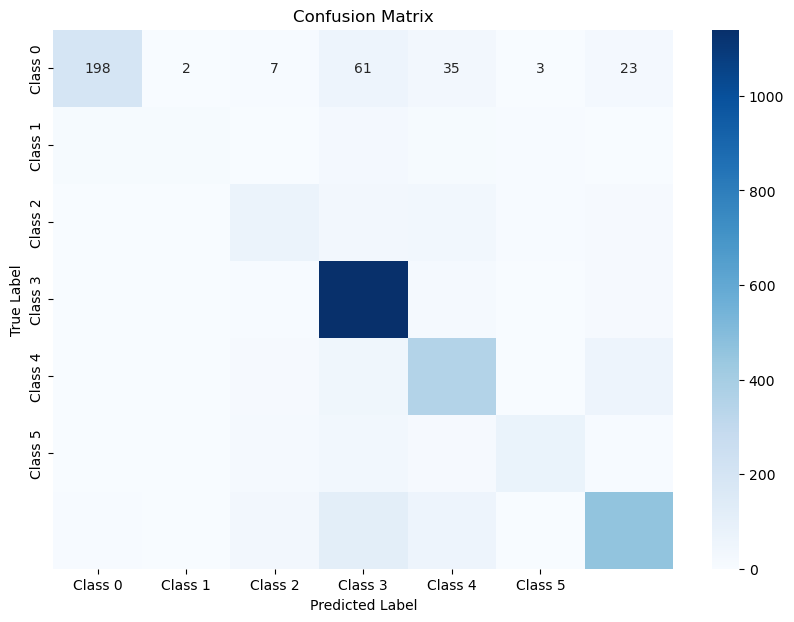

In [57]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(6)], yticklabels=[f'Class {i}' for i in range(6)])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()